<a href="https://colab.research.google.com/github/LucioJuniorMachado/recommendation_system/blob/main/image_similarity_recommendations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Similar Product Recommendations
> A tutorial on building a recommender system that will find similar looking products

- toc: true
- badges: true
- comments: true
- categories: [similarity vision]
- image:

In [6]:
#hide
%%writefile kaggle.json
{"username":"<your kaggle username>","key":"<your kaggle api key>"}

Writing kaggle.json


In [ ]:
#hide
!pip install -q -U kaggle
!pip install --upgrade --force-reinstall --no-deps kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.6.17-py3-none-any.whl size=105786 sha256=4aa36ef2495ce5954fab4686f6c2dde550d129427b9ae5383774da559dd8b0e8
  Stored in directory: /root/.cache/pip/wheels/9f/af/22/bf406f913dc7506a485e60dce8143741abd0a92a19337d83a3
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.6.17
    Uninstalling kaggle-1.6.17:
      Successfully uninstalled kaggle-1.6.17


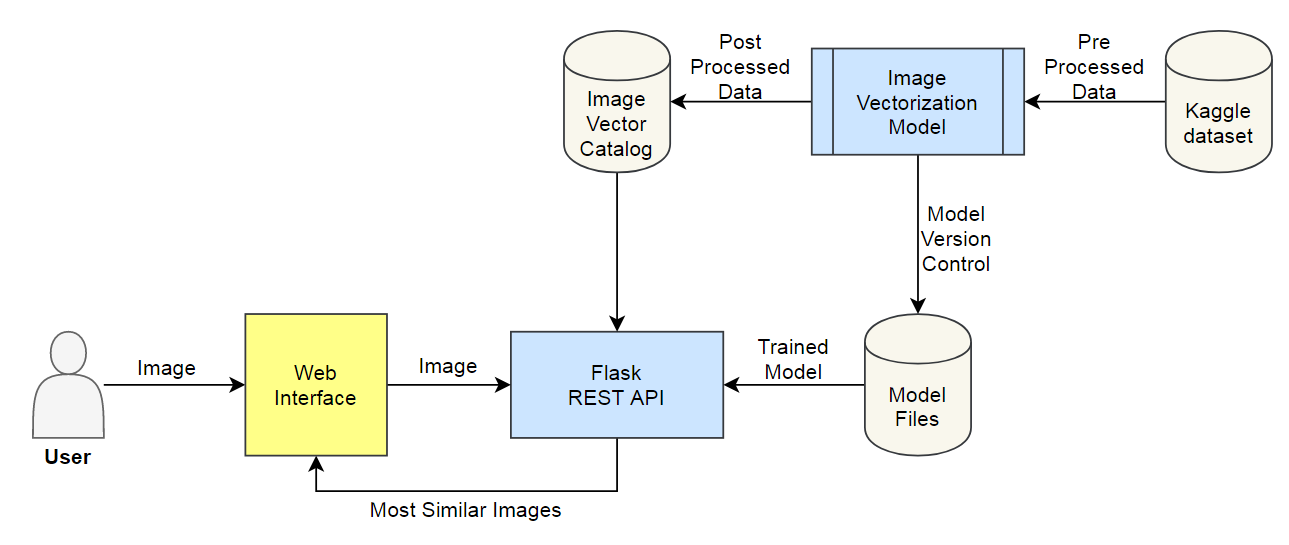

### Choice of variables

- Image Encoder: Any pre-trained image classification model can be selected. These models are commonly known as encoders because their job is to encode an image into a feature vector. In our case, we analyzed four encoders named 1) MobileNet, 2) EfficientNet, 3) ResNet and 4) [BiT](https://tfhub.dev/google/bit/m-r152x4/1). After some basic research, we decided to select BiT model because of its performance. I selected the BiT-M-50x3 variant of model which is of size 748 MB. More details about this architecture can be found on the official page [here](https://tfhub.dev/google/bit/m-r50x3/1).
- Vector Similarity System: Images are represented in a fixed-length feature vector format. For the given input vector, we need to find the TopK most similar vectors, keeping the memory efficiency and real-time retrival objective in mind. We explored the most popular techniques and listed down five of them: Annoy, Cosine distance, L1 distance, Locally Sensitive Hashing (LSH) and Image Deep Ranking. We selected Annoy because of its fast and efficient nature. More details about Annoy can be found on the official page [here](https://github.com/spotify/annoy).
- Dataset: This system is able to handle all kind of image dataset. Only the basic preprocessing (in step 1) would need some modifications depending on the dataset. We chose [Fashion Product Images (Small)](https://www.kaggle.com/bhaskar2443053/fashion-small?). Other examples can be [Food-11 image dataset](https://www.kaggle.com/trolukovich/food11-image-dataset?), and [Caltech 256 Image Dataset](https://www.kaggle.com/jessicali9530/caltech256?).

### Step 1: Data Acquisition

Download the raw image dataset into a directory. Categorize these images into their respective category directories. Make sure that images are of the same type, JPEG recommended. We will also process the metadata and store it in a serialized file, CSV recommended.

In [ ]:
#hide-output
# downloading raw images from kaggle
!kaggle datasets download -d paramaggarwal/fashion-product-images-small
!unzip fashion-product-images-small.zip

Streaming output truncated to the last 5000 lines.
  inflating: myntradataset/images/58131.jpg  
  inflating: myntradataset/images/58132.jpg  
  inflating: myntradataset/images/58133.jpg  
  inflating: myntradataset/images/58135.jpg  
  inflating: myntradataset/images/58136.jpg  
  inflating: myntradataset/images/58137.jpg  
  inflating: myntradataset/images/58138.jpg  
  inflating: myntradataset/images/58139.jpg  
  inflating: myntradataset/images/5814.jpg  
  inflating: myntradataset/images/58140.jpg  
  inflating: myntradataset/images/58141.jpg  
  inflating: myntradataset/images/58143.jpg  
  inflating: myntradataset/images/58144.jpg  
  inflating: myntradataset/images/58145.jpg  
  inflating: myntradataset/images/58146.jpg  
  inflating: myntradataset/images/58147.jpg  
  inflating: myntradataset/images/58148.jpg  
  inflating: myntradataset/images/58149.jpg  
  inflating: myntradataset/images/5815.jpg  
  inflating: myntradataset/images/58150.jpg  
  inflating: myntradataset/imag

In [5]:
import pandas as pd
from shutil import move
import os
from tqdm import tqdm

os.mkdir('/content/Fashion_data')
os.chdir('/content/Fashion_data')

df = pd.read_csv('/content/styles.csv', usecols=['id','masterCategory']).reset_index()
df['id'] = df['id'].astype('str')

all_images = os.listdir('/content/images/')
co = 0
os.mkdir('/content/Fashion_data/categories')
for image in tqdm(all_images):
    category = df[df['id'] == image.split('.')[0]]['masterCategory']
    category = str(list(category)[0])
    if not os.path.exists(os.path.join('/content/Fashion_data/categories', category)):
        os.mkdir(os.path.join('/content/Fashion_data/categories', category))
    path_from = os.path.join('/content/images', image)
    path_to = os.path.join('/content/Fashion_data/categories', category, image)
    move(path_from, path_to)
    co += 1
print('Moved {} images.'.format(co))

100%|██████████| 44441/44441 [03:15<00:00, 227.44it/s]

Moved 44441 images.


### Step 3: Image Vectorization
Now, we will use the encoder (prepared in step 2) to encode the images (prepared in step 1). We will save feature vector of each image as an array in a directory. After processing, we will save these embeddings for later use.

In [7]:
#hide
import tensorflow as tf
from pathlib import Path
import numpy as np
import os
from tqdm import tqdm
tqdm.pandas()

In [8]:
img_paths = []
for path in Path('/content/Fashion_data/categories').rglob('*.jpg'):
  img_paths.append(path)
np.random.shuffle(img_paths)

In [9]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.io.decode_jpeg(img, channels=3)
  img = tf.image.resize_with_pad(img, 224, 224)
  img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  return img

In [10]:
imgvec_path = '/content/img_vectors/'
Path(imgvec_path).mkdir(parents=True, exist_ok=True)

### Step 4: Metadata and Indexing

We will assign a unique id to each image and create dictionaries to locate information of this image: 1) Image id to Image name dictionary, 2) Image id to image feature vector dictionary, and 3) (optional) Image id to metadata product id dictionary. We will also create an image id to image feature vector indexing. Then we will save these dictionaries and index object for later use.

In [11]:
#hide
import pandas as pd
import glob
import os
import numpy as np
from tqdm import tqdm
tqdm.pandas()
!pip install -q annoy
import json
from annoy import AnnoyIndex
from scipy import spatial
import pickle
from IPython.display import Image as dispImage

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 15.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


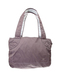

In [12]:
test_img = '/content/Fashion_data/categories/Accessories/1941.jpg'
dispImage(test_img)

In [13]:
def match_id(fname):
  return styles.index[styles.id==fname].values[0]

In [14]:
# Defining data structures as empty dict
file_index_to_file_name = {}
file_index_to_file_vector = {}
file_index_to_product_id = {}

# Configuring annoy parameters
dims = 256
n_nearest_neighbors = 20
trees = 10000

# Reads all file names which stores feature vectors
allfiles = glob.glob('/content/img_vectors/*.npz')

t = AnnoyIndex(dims, metric='angular')

In [15]:
for findex, fname in tqdm(enumerate(allfiles)):
  file_vector = np.loadtxt(fname)
  file_name = os.path.basename(fname).split('.')[0]
  file_index_to_file_name[findex] = file_name
  file_index_to_file_vector[findex] = file_vector
  try:
    file_index_to_product_id[findex] = match_id(file_name)
  except IndexError:
    pass
  t.add_item(findex, file_vector)

0it [00:00, ?it/s]


In [16]:
#hide-output
t.build(trees)
t.save('t.ann')

True

In [17]:
#hide
file_path = '/content/drive/MyDrive/ImgSim/'

In [18]:
import os

# Ensure the directory exists by creating it if it doesn't
os.makedirs(file_path, exist_ok=True)

# Now save the Annoy index
t.save(file_path + 'indexer.ann')

# ... rest of the code for saving pickles remains unchanged

True

In [19]:
t.save(file_path+'indexer.ann')
pickle.dump(file_index_to_file_name, open(file_path+"file_index_to_file_name.p", "wb"))
pickle.dump(file_index_to_file_vector, open(file_path+"file_index_to_file_vector.p", "wb"))
pickle.dump(file_index_to_product_id, open(file_path+"file_index_to_product_id.p", "wb"))

## Step 5: Local Testing

We will load a random image and find top-K most similar images.

In [20]:
#hide
from PIL import Image
import matplotlib.image as mpimg

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


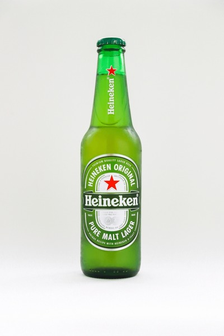

In [23]:
!pip install tensorflow
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.applications import efficientnet
import numpy as np

# Assuming you want to use EfficientNetB0 for feature extraction
module = efficientnet.EfficientNetB0(weights='imagenet', include_top=False) # Define the feature extraction module

img_addr = 'https://www.shutterstock.com/image-photo/poltava-ukraine-april-14-2024-600nw-2450478941.jpg'

!wget -q -O img.jpg $img_addr
test_img = 'img.jpg'
topK = 4

# Preprocess the image
img = load_img(test_img, target_size=(224, 224))  # Load and resize image using Keras utility
img_array = img_to_array(img) # Convert the PIL image to a NumPy array
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

test_vec = np.squeeze(module.predict(img_array)) # Extract features and squeeze the output

basewidth = 224
img = Image.open(test_img)
wpercent = (basewidth/float(img.size[0]))
hsize = int((float(img.size[1])*float(wpercent)))
# Replace Image.ANTIALIAS with Image.Resampling.LANCZOS
img = img.resize((basewidth,hsize), Image.Resampling.LANCZOS)
img

## Step 6: API Call

We will build two kinds of API - 1) UI based API using Streamlit, and 2) REST API using Flask. In both the cases, we will receive an image from user, encode it with our image encoder, find TopK similar vectors using Indexing object, and retrieve the image (and metadata) using dictionaries. We send these images (and metadata) back to the user.

In [24]:
#hide
import os
import time

In [25]:
#hide
root_path = '/content/drive/MyDrive/ImgSim'

In [26]:
%%writefile utils.py
### ----utils.py---- ###

import os
import tensorflow as tf
from annoy import AnnoyIndex

root_path = '/content/drive/MyDrive/ImgSim'

class Encoder:
  encoder = tf.keras.models.load_model(os.path.join(root_path, 'bit_feature_extractor'))

class Indexer:
  dims = 256
  topK = 6
  indexer = AnnoyIndex(dims, 'angular')
  indexer.load(os.path.join(root_path, 'indexer.ann'))

encoder = Encoder()
indexer = Indexer()

Writing utils.py


### Streamlit App

In [27]:
%%writefile app.py
### ----app.py---- ###

import streamlit as st
import pandas as pd
import numpy as np
from PIL import Image
from annoy import AnnoyIndex
import glob
import os
import tensorflow as tf
import tarfile
import pickle
from pathlib import Path
import time
from utils import encoder, indexer

root_path = '/content/drive/MyDrive/ImgSim'

start_time = time.time()
encoder = encoder.encoder
print("---Encoder--- %s seconds ---" % (time.time() - start_time))

topK = 6

start_time = time.time()
t = indexer.indexer
print("---Indexer--- %s seconds ---" % (time.time() - start_time))

# load the meta data
meta_data = pd.read_csv(os.path.join(root_path, 'styles.csv'))

# load the mappings
file_index_to_file_name = pickle.load(open(os.path.join(root_path ,'file_index_to_file_name.p'), 'rb'))
file_index_to_file_vector = pickle.load(open(os.path.join(root_path ,'file_index_to_file_vector.p'), 'rb'))
file_index_to_product_id = pickle.load(open(os.path.join(root_path ,'file_index_to_product_id.p'), 'rb'))

# load image path mapping
path_dict = {}
for path in Path('/content/Fashion_data/categories').rglob('*.jpg'):
  path_dict[path.name] = path

def load_img(path):
  img = tf.io.read_file(path)
  img = tf.io.decode_jpeg(img, channels=3)
  img = tf.image.resize_with_pad(img, 224, 224)
  img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  return img

query_path = '/content/user_query.jpg'

st.title("Image Similarity App")

uploaded_file = st.file_uploader("Choose an image...", type="jpg")

if uploaded_file is not None:
    image = Image.open(uploaded_file)
    image.save(query_path)
    st.image(image, caption='Uploaded Image.', use_column_width=True)
    st.write("")
    st.write("Top similar images...")

    start_time = time.time()
    test_vec = np.squeeze(encoder(load_img(query_path)))
    print("---Encoding--- %s seconds ---" % (time.time() - start_time))

    start_time = time.time()
    nns = t.get_nns_by_vector(test_vec, n=topK)
    print("---SimilarityIndex--- %s seconds ---" % (time.time() - start_time))

    img_files = []
    img_captions = []

    start_time = time.time()
    for i in nns:
      #image files
      img_path = str(path_dict[file_index_to_file_name[i]+'.jpg'])
      img_file = Image.open(img_path)
      img_files.append(img_file)
      #image captions
      item_id = file_index_to_product_id[i]
      img_caption = '\n'.join([str(j) for j in list(meta_data.loc[item_id].values[-5:])])
      img_captions.append(img_caption)
    print("---Output--- %s seconds ---" % (time.time() - start_time))

    st.image(img_files, caption=img_captions, width=200)

Writing app.py


### Flask API

#### server-side

In [28]:
%%writefile flask_app.py
### ----flask_app.py---- ###

import pandas as pd
import numpy as np
from PIL import Image
from annoy import AnnoyIndex
import glob
import os
import tensorflow as tf
import tarfile
import pickle
from pathlib import Path
import time
from utils import encoder, indexer
import io
import base64

from flask import Flask, request, jsonify, send_file

_PPATH = '/content/drive/MyDrive/ImgSim/'

start_time = time.time()
encoder = encoder.encoder
print("---Encoder--- %s seconds ---" % (time.time() - start_time))

topK = 6

start_time = time.time()
t = indexer.indexer
print("---Indexer--- %s seconds ---" % (time.time() - start_time))

# load the meta data
meta_data = pd.read_csv(_PPATH+'styles.csv')

# load the mappings
file_index_to_file_name = pickle.load(open(_PPATH+'file_index_to_file_name.p', 'rb'))
file_index_to_file_vector = pickle.load(open(_PPATH+'file_index_to_file_vector.p', 'rb'))
file_index_to_product_id = pickle.load(open(_PPATH+'file_index_to_product_id.p', 'rb'))

# load image path mapping
path_dict = {}
for path in Path('/content/Fashion_data/categories').rglob('*.jpg'):
  path_dict[path.name] = path

def load_img(path):
  img = tf.io.read_file(path)
  img = tf.io.decode_jpeg(img, channels=3)
  img = tf.image.resize_with_pad(img, 224, 224)
  img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  return img

query_path = '/content/user_query.jpg'

def get_encoded_img(img):
    img_byte_arr = io.BytesIO()
    img.save(img_byte_arr, format='PNG')
    my_encoded_img = base64.encodebytes(img_byte_arr.getvalue()).decode('ascii')
    return my_encoded_img


app = Flask(__name__)

@app.route("/fashion", methods=["POST"])
def home():
    file = request.files['image']
    # Read the image via file.stream
    img = Image.open(file.stream)
    img.save(query_path)

    start_time = time.time()
    test_vec = np.squeeze(encoder(load_img(query_path)))
    print("---Encoding--- %s seconds ---" % (time.time() - start_time))

    start_time = time.time()
    nns = t.get_nns_by_vector(test_vec, n=topK)
    print("---SimilarityIndex--- %s seconds ---" % (time.time() - start_time))

    img_files = {}
    img_captions = {}

    start_time = time.time()
    for count, i in enumerate(nns):
      #image files
      img_path = str(path_dict[file_index_to_file_name[i]+'.jpg'])
      img_file = Image.open(img_path)
      img_files[count] = get_encoded_img(img_file)
      #image captions
      item_id = file_index_to_product_id[i]
      img_caption = '\n'.join([str(j) for j in list(meta_data.loc[item_id].values[-5:])])
      img_captions[count] = img_caption
    print("---Output--- %s seconds ---" % (time.time() - start_time))

    return jsonify(img_files)

app.run(debug=True)

Writing flask_app.py


In [29]:
!nohup python3 -u flask_app.py &

nohup: appending output to 'nohup.out'


In [37]:
import pandas as pd
# Assuming 'df' is your DataFrame and contains a column named 'product_name'
# Replace this with your actual DataFrame and column name

# Example DataFrame (replace with your actual data)
data = {'product_name': ['Heineken Lager Beer', 'Heineken Light', 'Amstel Light', 'Budweiser', 'Corona Extra', 'Stella Artois', 'Guinness Draught', 'Miller Lite', 'Coors Light', 'Modelo Especial']}
df = pd.DataFrame(data)

# Find products similar to Heineken based on appearance
# This is a placeholder; you'll need to replace it with your actual logic.
# The following example just returns the first 10 rows of the dataframe.
# You would implement a similarity measure based on image features, color, shape etc,
# from the dataframe, and then filter out products that match your defined criteria
heineken_related = df.head(10)

heineken_related

,product_name
0,Heineken Lager Beer
1,Heineken Light
2,Amstel Light
3,Budweiser
4,Corona Extra
5,Stella Artois
6,Guinness Draught
7,Miller Lite
8,Coors Light
9,Modelo Especial
